In [1]:
from transformers import BertTokenizer, BertModel

import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

from dataset import Dataset

import sys
import numpy as np
import pickle

np.set_printoptions(threshold=sys.maxsize)

In [2]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout):
        super(KimCNN, self).__init__()
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
#         self.static = static
#         self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.sigmoid(logit)
        return output

In [3]:
class MLE(nn.Module):
    def __init__(self):
        super(MLE, self).__init__()
        
        layers = []
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Linear(768, 6))
        layers.append(nn.Dropout(0.1))
        layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
    
    def forward(self, tokens, masks=None):
        
        output = self.net(tokens)
        return output

In [4]:
processed_train_path = "../data/pre_processed/"
train_dataset = Dataset(processed_train_path)

In [5]:
processed_train_path = "../data/test_pre_processed/"
test_dataset = Dataset(processed_train_path)

In [6]:
classifier = MLE()

n_epochs = 1
lr = 0.01

optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

In [7]:
# for epoch in range(n_epochs):
#     train_loss = 0
#     print(f"Current epoch {epoch} out of {n_epochs} ")
#     for file_index in range(len(train_dataset)-1):
#         train_loss = 0
#         batch, labels = train_dataset[file_index]
#         for batch_index in range(batch.shape[0]):
            
#             batch_sample = batch[batch_index].T.float()
#             batch_sample = torch.mean(batch_sample, 1)
            
#             labels_sample, indices = labels[batch_index].max(0)
#             labels_sample = torch.tensor([indices.data], dtype=torch.long)
            
#             optimizer.zero_grad()
#             classifier.train()

#             output = classifier(batch_sample)
#             output = output.reshape(1, 6)
            
#             loss = loss_fn(output, labels_sample)
#             train_loss += loss
#             loss.backward()
#             optimizer.step()
#         print(f'Train loss: {train_loss}')

# CNN training

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


class CNN_Text(nn.Module):
    
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout):
        super(CNN_Text, self).__init__()
        
        V = embed_num
        D = embed_dim
        C = class_num
        Ci = 1
        Co = kernel_num
        Ks = kernel_sizes

#         self.embed = nn.Embedding(V, D)
        self.convs = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)

#         if self.args.static:
#             self.embed.weight.requires_grad = False

    def forward(self, x):
#         x = self.embed(x)  # (N, W, D)
    
        x = x.unsqueeze(1)  # (N, Ci, W, D)

        x = [torch.tanh(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)

        x = torch.cat(x, 1)

        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        return logit

In [13]:
# initialize model
device = "cuda" if torch.cuda.is_available() else "cpu"
# cnn_model = KimCNN()


n_epochs = 100
lr = 0.01

kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.5

cnn_classifier = CNN_Text(
    embed_dim=768,
    embed_num=512,
    class_num=6,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout
).to(device)

optimizer = torch.optim.Adam(cnn_classifier.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss().to(device)

In [10]:

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, x_train, x_test, y_train, y_test, ydatacolors=['b','r']):

    y = np.random.random(size=(100,1))
    ax.plot(x_train, y_train, ydatacolors[0])
    ax.plot(x_test, y_test, ydatacolors[1])
    fig.canvas.draw()

<IPython.core.display.Javascript object>


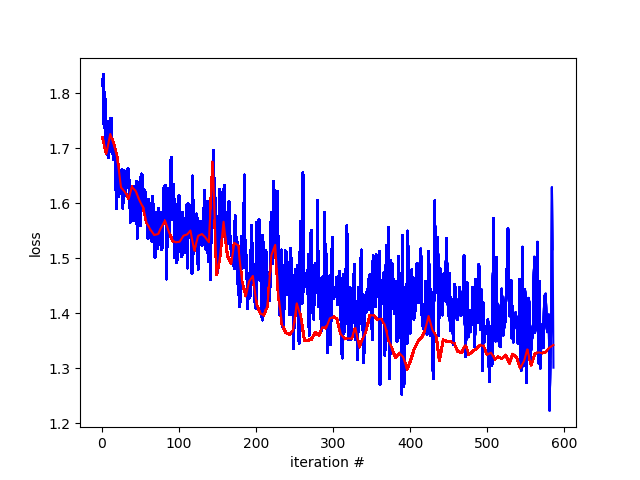

Current epoch 0 out of 100 
Epoch: [0/100] batch: [0/19] Train loss: 1.7286124229431152 Validation loss: 1.7190645933151245
Epoch: [0/100] batch: [1/19] Train loss: 1.834174633026123 Validation loss: 1.7190645933151245
Epoch: [0/100] batch: [2/19] Train loss: 1.7373440265655518 Validation loss: 1.7190645933151245
Epoch: [0/100] batch: [3/19] Train loss: 1.8007557392120361 Validation loss: 1.7190645933151245
Epoch: [0/100] batch: [4/19] Train loss: 1.7277445793151855 Validation loss: 1.7190645933151245
Epoch: [0/100] batch: [5/19] Train loss: 1.710146188735962 Validation loss: 1.6900856494903564
Epoch: [0/100] batch: [6/19] Train loss: 1.7486655712127686 Validation loss: 1.6900856494903564
Epoch: [0/100] batch: [7/19] Train loss: 1.6868423223495483 Validation loss: 1.6900856494903564
Epoch: [0/100] batch: [8/19] Train loss: 1.6826521158218384 Validation loss: 1.6900856494903564
Epoch: [0/100] batch: [9/19] Train loss: 1.7122693061828613 Validation loss: 1.6900856494903564
Epoch: [0/100]

Epoch: [4/100] batch: [8/19] Train loss: 1.5608553886413574 Validation loss: 1.5684149265289307
Epoch: [4/100] batch: [9/19] Train loss: 1.6258718967437744 Validation loss: 1.5684149265289307
Epoch: [4/100] batch: [10/19] Train loss: 1.6038100719451904 Validation loss: 1.5479001998901367
Epoch: [4/100] batch: [11/19] Train loss: 1.5432008504867554 Validation loss: 1.5479001998901367
Epoch: [4/100] batch: [12/19] Train loss: 1.6493842601776123 Validation loss: 1.5479001998901367
Epoch: [4/100] batch: [13/19] Train loss: 1.6832597255706787 Validation loss: 1.5479001998901367
Epoch: [4/100] batch: [14/19] Train loss: 1.585170865058899 Validation loss: 1.5479001998901367
Epoch: [4/100] batch: [15/19] Train loss: 1.5784426927566528 Validation loss: 1.5316123962402344
Epoch: [4/100] batch: [16/19] Train loss: 1.6344969272613525 Validation loss: 1.5316123962402344
Epoch: [4/100] batch: [17/19] Train loss: 1.5939929485321045 Validation loss: 1.5316123962402344
Epoch: [4/100] batch: [18/19] Tra

Epoch: [8/100] batch: [17/19] Train loss: 1.5137333869934082 Validation loss: 1.490581750869751
Epoch: [8/100] batch: [18/19] Train loss: 1.4911584854125977 Validation loss: 1.490581750869751
Current epoch 9 out of 100 
Epoch: [9/100] batch: [0/19] Train loss: 1.585067629814148 Validation loss: 1.5276700258255005
Epoch: [9/100] batch: [1/19] Train loss: 1.57735013961792 Validation loss: 1.5276700258255005
Epoch: [9/100] batch: [2/19] Train loss: 1.5211477279663086 Validation loss: 1.5276700258255005
Epoch: [9/100] batch: [3/19] Train loss: 1.5379858016967773 Validation loss: 1.5276700258255005
Epoch: [9/100] batch: [4/19] Train loss: 1.5189915895462036 Validation loss: 1.5276700258255005
Epoch: [9/100] batch: [5/19] Train loss: 1.604418158531189 Validation loss: 1.5228677988052368
Epoch: [9/100] batch: [6/19] Train loss: 1.4883701801300049 Validation loss: 1.5228677988052368
Epoch: [9/100] batch: [7/19] Train loss: 1.411839485168457 Validation loss: 1.5228677988052368
Epoch: [9/100] ba

Epoch: [13/100] batch: [6/19] Train loss: 1.487053632736206 Validation loss: 1.4177438020706177
Epoch: [13/100] batch: [7/19] Train loss: 1.3951166868209839 Validation loss: 1.4177438020706177
Epoch: [13/100] batch: [8/19] Train loss: 1.344443917274475 Validation loss: 1.4177438020706177
Epoch: [13/100] batch: [9/19] Train loss: 1.4957306385040283 Validation loss: 1.4177438020706177
Epoch: [13/100] batch: [10/19] Train loss: 1.4518427848815918 Validation loss: 1.393947720527649
Epoch: [13/100] batch: [11/19] Train loss: 1.4809292554855347 Validation loss: 1.393947720527649
Epoch: [13/100] batch: [12/19] Train loss: 1.4181393384933472 Validation loss: 1.393947720527649
Epoch: [13/100] batch: [13/19] Train loss: 1.654786229133606 Validation loss: 1.393947720527649
Epoch: [13/100] batch: [14/19] Train loss: 1.438869833946228 Validation loss: 1.393947720527649
Epoch: [13/100] batch: [15/19] Train loss: 1.402610182762146 Validation loss: 1.3502179384231567
Epoch: [13/100] batch: [16/19] Tra

Epoch: [17/100] batch: [14/19] Train loss: 1.3691020011901855 Validation loss: 1.3381725549697876
Epoch: [17/100] batch: [15/19] Train loss: 1.3986694812774658 Validation loss: 1.353708267211914
Epoch: [17/100] batch: [16/19] Train loss: 1.3100188970565796 Validation loss: 1.353708267211914
Epoch: [17/100] batch: [17/19] Train loss: 1.4158673286437988 Validation loss: 1.353708267211914
Epoch: [17/100] batch: [18/19] Train loss: 1.404457449913025 Validation loss: 1.353708267211914
Current epoch 18 out of 100 
Epoch: [18/100] batch: [0/19] Train loss: 1.4035251140594482 Validation loss: 1.369828701019287
Epoch: [18/100] batch: [1/19] Train loss: 1.4379050731658936 Validation loss: 1.369828701019287
Epoch: [18/100] batch: [2/19] Train loss: 1.4322444200515747 Validation loss: 1.369828701019287
Epoch: [18/100] batch: [3/19] Train loss: 1.4605847597122192 Validation loss: 1.369828701019287
Epoch: [18/100] batch: [4/19] Train loss: 1.405765414237976 Validation loss: 1.369828701019287
Epoch: 

Epoch: [22/100] batch: [2/19] Train loss: 1.4090420007705688 Validation loss: 1.366943597793579
Epoch: [22/100] batch: [3/19] Train loss: 1.3614780902862549 Validation loss: 1.366943597793579
Epoch: [22/100] batch: [4/19] Train loss: 1.4262510538101196 Validation loss: 1.366943597793579
Epoch: [22/100] batch: [5/19] Train loss: 1.4463603496551514 Validation loss: 1.394604206085205
Epoch: [22/100] batch: [6/19] Train loss: 1.4651825428009033 Validation loss: 1.394604206085205
Epoch: [22/100] batch: [7/19] Train loss: 1.3587331771850586 Validation loss: 1.394604206085205
Epoch: [22/100] batch: [8/19] Train loss: 1.4421452283859253 Validation loss: 1.394604206085205
Epoch: [22/100] batch: [9/19] Train loss: 1.416304349899292 Validation loss: 1.394604206085205
Epoch: [22/100] batch: [10/19] Train loss: 1.416232943534851 Validation loss: 1.3693125247955322
Epoch: [22/100] batch: [11/19] Train loss: 1.2804852724075317 Validation loss: 1.3693125247955322
Epoch: [22/100] batch: [12/19] Train l

Epoch: [26/100] batch: [10/19] Train loss: 1.383257269859314 Validation loss: 1.3279078006744385
Epoch: [26/100] batch: [11/19] Train loss: 1.3038705587387085 Validation loss: 1.3279078006744385
Epoch: [26/100] batch: [12/19] Train loss: 1.313483715057373 Validation loss: 1.3279078006744385
Epoch: [26/100] batch: [13/19] Train loss: 1.5728790760040283 Validation loss: 1.3279078006744385
Epoch: [26/100] batch: [14/19] Train loss: 1.4727777242660522 Validation loss: 1.3279078006744385
Epoch: [26/100] batch: [15/19] Train loss: 1.3560675382614136 Validation loss: 1.3158940076828003
Epoch: [26/100] batch: [16/19] Train loss: 1.348921298980713 Validation loss: 1.3158940076828003
Epoch: [26/100] batch: [17/19] Train loss: 1.5009346008300781 Validation loss: 1.3158940076828003
Epoch: [26/100] batch: [18/19] Train loss: 1.3600585460662842 Validation loss: 1.3158940076828003
Current epoch 27 out of 100 
Epoch: [27/100] batch: [0/19] Train loss: 1.3573830127716064 Validation loss: 1.320574522018

In [ ]:
%matplotlib notebook
fig,ax = plt.subplots(1,1)
ax.set_xlabel('iteration #')
ax.set_ylabel('loss')
# ax.axis(xmin=0, xmax=None, ymin=0, ymax=None)

train_plot_x = []
train_plot_y = []
test_plot_x  = []
test_plot_y  = []
iteration = 0

for epoch in range(n_epochs):
    train_loss = 0
    print(f"Current epoch {epoch} out of {n_epochs} ")
    for file_index in range(len(train_dataset)-1):
        iteration += 1

        batch, labels = train_dataset[file_index]

        _, indices = labels.max(1)
            
        optimizer.zero_grad()
        cnn_classifier.train()

        output = cnn_classifier(batch.float().to(device))
        output = output.reshape(batch.shape[0], 6)
    
        loss = loss_fn(output, indices.to(device))
        
        train_plot_x.append(iteration)
        train_plot_y.append(loss.detach().cpu())

        loss.backward()
        optimizer.step()
        
        if not file_index % 5:
            cnn_classifier.eval()
            test_loss = 0
            for test_index in range(len(test_dataset)-1):
                test_batch, test_labels = test_dataset[test_index]
                _, test_indices = test_labels.max(1)
                output = cnn_classifier(test_batch.float().to(device))
                output = output.reshape(test_batch.shape[0], 6)
                loss = loss_fn(output, test_indices.to(device))
                test_loss += loss.detach().cpu()
            
            test_plot_x.append(iteration)
            test_plot_y.append(test_loss/(len(test_dataset)-1))
            cnn_classifier.train()


        print(f'Epoch: [{epoch}/{n_epochs}] batch: [{file_index}/{len(train_dataset)-1}] Train loss: {loss} Validation loss: {test_loss/(len(test_dataset)-1)}')
        pltsin(ax, train_plot_x, test_plot_x, train_plot_y, test_plot_y, ['b', 'r'])
    torch.save(cnn_classifier.state_dict(), f"cnn_models/model_epoch_{epoch}.p")
